In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn as nn
import torch.optim as optim
import os
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import interpolate, upsample

In [2]:
import sys
sys.path.insert(1, '../')

In [3]:
import numpy as np

import torch


from source.mfa.celeba_dataset import FlattenTransform
from source.mfa.mfa import MFA
from source.wgangp.wgan_model import WGAN_GP
from source.dcgan.dcgan_model import Discriminator, Generator, DCGAN
from source.ins_score.Inception_Score_function import Inception_Score
from source.fid.FID import Frеchet_Inception_Distance
from source.mfa.mfa_torch import get_latent_posterior_mean, init_raw_parms_from_gmm, get_max_posterior_component, generate_from_posterior
from source.pix2pix.pix2pix import Pix2PixGen

In [4]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

In [5]:
predictor = torchvision.models.inception_v3(pretrained=True).to(device)

In [30]:
transform = transforms.Compose(
    [transforms.Resize(299),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

In [8]:
class Generated_images(Dataset):

    def __init__(self, z, generator, transform=None, mode=None):
        self.z = z
        self.generator = generator
        self.transform = transform
        self.mode=mode

    def __len__(self):
        return len(self.z)

    def __getitem__(self, idx):
        from PIL import Image

        with torch.no_grad():
            if self.mode=='DCGAN':
                image = np.transpose(self.generator(self.z[idx].reshape(1,Z_LATENT,1,1)).cpu().numpy().squeeze(),(1,2,0))
            elif self.mode=='WGAN':
                self.generator.eval()
                image = np.transpose(self.generator(self.z[idx].reshape(1,Z_LATENT)).cpu().numpy().squeeze(),(1,2,0))
        
        norm = plt.Normalize()
        image = norm(image)
        
        image = Image.fromarray(np.uint8(255*image))

        if self.transform:
            image = self.transform(image)

        return image

In [28]:
class MFADataset(Dataset):
    def __init__(self, samples,transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)
    

    def __getitem__(self, idx):
        from PIL import Image
        image = np.transpose(self.samples[idx].numpy(),(1,2,0))
        norm = plt.Normalize()
        image = norm(image)
        
        image = Image.fromarray(np.uint8(255*image))

        if self.transform:
            image = self.transform(image)
        
        return image

In [13]:
num_test = 20000

In [6]:
# Path for dataset
DATA_PATH = '../../generative-models/notebooks/data'

In [33]:
transform_celeba = transforms.Compose(
    [transforms.CenterCrop(178),
    transforms.Resize(299),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CelebA(root=DATA_PATH, split='train',
                                        download=True, transform=transform_celeba)
class CelebAdataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return num_test
    

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        
        return image
    
images_set_celeba = CelebAdataset(trainset)

Files already downloaded and verified


In [8]:
transform_pix2pix = transforms.Compose(
    [transforms.CenterCrop(178),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    FlattenTransform()])

trainset_p = torchvision.datasets.CelebA(root=DATA_PATH, split='train',
                                        download=True, transform=transform_pix2pix)
class PIX2PIXDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return num_test
    

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        
        return image
    
images_set_celeba_pix2pix = PIX2PIXDataset(trainset_p)

Files already downloaded and verified


## DCGAN

In [46]:
# Size of z latent vector
Z_LATENT = 100

# Size of generator output (channels)
GENERATOR_PARAMETER = 64

#  Size of discriminator output (channels)
DISCRIMINATOR_PARAMETER = 64

# Path for logs
LOG_PATH = '../../generative-models/notebooks/dcgan_train_process_2'

In [47]:
model = DCGAN(GENERATOR_PARAMETER, DISCRIMINATOR_PARAMETER,Z_LATENT,device)

In [48]:
checkpoint = torch.load(os.path.join(LOG_PATH,'131000_generator.ckpt'))
model.G.load_state_dict(checkpoint)

<All keys matched successfully>

In [49]:
z_DCGAN = torch.randn(num_test, Z_LATENT, 1, 1, device = device)

In [50]:
images_set_DCGAN = Generated_images(z_DCGAN,model.G,transform=transform,mode='DCGAN')

## WGAN_GP

In [51]:
# Size of z latent vector
Z_LATENT= 100

# Path for logs
LOG_PATH = '../../'

In [52]:
wgangp_model = WGAN_GP(3, Z_LATENT).to(device)
wgangp_model.G.load_state_dict(torch.load(os.path.join(LOG_PATH,'wgangp_gen_40.pt')))

<All keys matched successfully>

In [53]:
z_WGAN = torch.randn(num_test, Z_LATENT,device = device)

In [54]:
images_set_WGAN = Generated_images(z_WGAN,wgangp_model.G,transform=transform,mode='WGAN')

## MFA FA

In [15]:
# Path for logs
LOG_PATH = '../../'

In [16]:
fa_gmm_model = MFA()

In [17]:
fa_gmm_model.load(os.path.join(LOG_PATH,'e1_fa_256_saved_gmm.pkl'))

In [18]:
fa_samples = fa_gmm_model.draw_samples(num_test, False)

In [19]:
fa_samples = torch.Tensor(fa_samples.reshape(num_test,3,64,64))

In [ ]:
images_set_MFA = MFADataset(fa_samples,transform=transform)

## MFA PPCA

In [88]:
# Path for logs
LOG_PATH = '../../'

In [89]:
ppca_gmm_model = MFA()

In [90]:
ppca_gmm_model.load(os.path.join(LOG_PATH,'e3_ppca_256_saved_gmm.pkl'))

In [91]:
ppca_samples = ppca_gmm_model.draw_samples(num_test, False)

In [92]:
ppca_samples = torch.Tensor(ppca_samples.reshape(num_test,3,64,64))

In [94]:
images_set_MFA_PCA = MFADataset(ppca_samples,transform=transform)

In [ ]:
for X in pix2pix_loader:
    X_hat = generate_from_posterior(X, G_PI, G_MU, G_A, G_D)

    X_sharp = interpolate(pix2pix_G(interpolate(X_hat.view(-1, 3, 64, 64), size=256)), size=64)
    
    images_pix2pix.append(X_sharp.cpu().)

## PIX2PIX+MFA

In [9]:
# Path for logs
LOG_PATH = '../../'

In [10]:
pix2pix_G = Pix2PixGen().cuda()

In [11]:
pix2pix_G.load_state_dict(torch.load(os.path.join(LOG_PATH,'e1_pix2pix_gen_1')))

<All keys matched successfully>

In [25]:
pix2pix_loader = DataLoader(images_set_celeba_pix2pix, batch_size=num_test//2000, shuffle=True)

G_PI, G_MU, G_A, G_D = init_raw_parms_from_gmm(fa_gmm_model)

images_pix2pix=[]

for i,X in enumerate(pix2pix_loader):
    X = X.cpu()
    G_PI, G_MU, G_A, G_D = G_PI.cpu(), G_MU.cpu(), G_A.cpu(), G_D.cpu() 
    with torch.no_grad():
        X_hat = generate_from_posterior(X, G_PI, G_MU, G_A, G_D)

        X_sharp = interpolate(pix2pix_G(interpolate(X_hat.view(-1, 3, 64, 64).to(device), size=256)), size=64)
    
    images_pix2pix.append(X_sharp.cpu().numpy())
    if i%100==0:
        print(i)

0
100
200
300
400


In [26]:
images_pix2pix = torch.Tensor(np.vstack(images_pix2pix))

In [31]:
images_set_PIX2PIX = MFADataset(images_pix2pix,transform=transform)

## Calculate IS score

In [48]:
IS_DCGAN, IS_err_DCGAN = Inception_Score(images_set_DCGAN, predictor, n=10, bs=100)

In [54]:
print('Inception score for DCGAN equals %.3f+/-%.3f' % (IS_DCGAN,IS_err_DCGAN))

Inception score for DCGAN equals 2.330+/-0.032


In [50]:
IS_WGAN, IS_err_WGAN = Inception_Score(images_set_WGAN, predictor, n=10, bs=100)

In [55]:
print('Inception score for WGAN equals %.3f+/-%.3f' % (IS_WGAN,IS_err_WGAN))

Inception score for WGAN equals 2.403+/-0.039


In [52]:
IS_MFA, IS_err_MFA = Inception_Score(images_set_MFA, predictor, n=10, bs=100)

In [56]:
print('Inception score for MFA equals %.3f+/-%.3f' % (IS_MFA,IS_err_MFA))

Inception score for MFA equals 1.871+/-0.015


In [95]:
IS_MFA_PCA, IS_err_MFA_PCA = Inception_Score(images_set_MFA_PCA, predictor, n=10, bs=100)

In [96]:
print('Inception score for MFA PPCA equals %.3f+/-%.3f' % (IS_MFA_PCA,IS_err_MFA_PCA))

Inception score for MFA PPCA equals 1.608+/-0.012


In [38]:
IS_PIX2PIX, IS_err_PIX2PIX = Inception_Score(images_set_PIX2PIX, predictor, n=10, bs=50)

In [39]:
print('Inception score for PIX2PIX+MFA equals %.3f+/-%.3f' % (IS_PIX2PIX,IS_err_PIX2PIX))

Inception score for PIX2PIX+MFA equals 2.110+/-0.034


Text(0.5, 1.0, 'Inception Score')

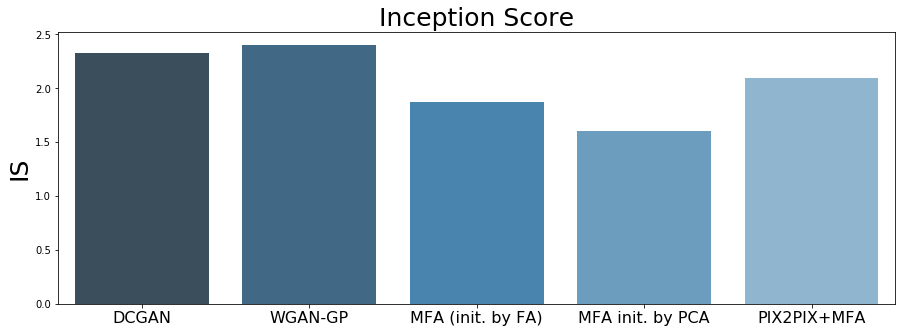

In [158]:
import seaborn as sns
import pandas as pd

bars = [IS_DCGAN, IS_WGAN, IS_MFA, IS_MFA_PCA, IS_PIX2PIX]



plt.figure(figsize=(15,5))
ax = sns.barplot(x=pd.Series(range(len(bars))),y=pd.Series(bars), palette="Blues_d")

ax.set_xticklabels(['DCGAN', 'WGAN-GP', 'MFA (init. by FA)', 'MFA init. by PCA', 'PIX2PIX+MFA'],fontdict={'fontsize':16})
ax.set_ylabel('IS',fontsize=25)
ax.set_title('Inception Score',fontsize=25)

## Calculate FID score

In [61]:
FID_DCGAN = Frеchet_Inception_Distance(images_set_celeba,images_set_DCGAN, predictor)

In [62]:
print('Frеchet Inception Distance for DCGAN equals %.3f' % (FID_DCGAN))

Frеchet Inception Distance for DCGAN equals 0.090


In [63]:
FID_WGAN = Frеchet_Inception_Distance(images_set_celeba,images_set_WGAN, predictor)

In [64]:
print('Frеchet Inception Distance for WGAN equals %.3f' % (FID_WGAN))

Frеchet Inception Distance for WGAN equals 0.075


In [65]:
FID_MFA = Frеchet_Inception_Distance(images_set_celeba,images_set_MFA, predictor)

In [66]:
print('Frеchet Inception Distance for MFA equals %.3f' % (FID_MFA))

Frеchet Inception Distance for MFA equals 0.125


In [98]:
FID_MFA_PCA = Frеchet_Inception_Distance(images_set_celeba,images_set_MFA_PCA, predictor)

In [99]:
print('Frеchet Inception Distance for MFA equals %.3f' % (FID_MFA_PCA))

Frеchet Inception Distance for MFA equals 0.115


In [34]:
FID_PIX2PIX = Frеchet_Inception_Distance(images_set_celeba,images_set_PIX2PIX, predictor, bs=50)

In [35]:
print('Frеchet Inception Distance for MFA equals %.3f' % (FID_PIX2PIX))

Frеchet Inception Distance for MFA equals 0.099


Text(0.5, 1.0, 'Frеchet Inception Distance')

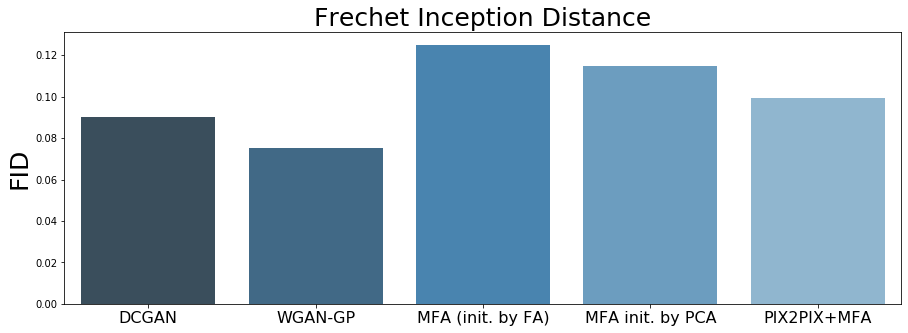

In [37]:
import seaborn as sns
import pandas as pd

bars = [FID_DCGAN, FID_WGAN, FID_MFA, FID_MFA_PCA, FID_PIX2PIX]


plt.figure(figsize=(15,5))
ax = sns.barplot(x=pd.Series(range(len(bars))),y=pd.Series(bars), palette="Blues_d")

ax.set_xticklabels(['DCGAN', 'WGAN-GP', 'MFA (init. by FA)', 'MFA init. by PCA', 'PIX2PIX+MFA'],fontdict={'fontsize':16})
ax.set_ylabel('FID',fontsize=25)
ax.set_title('Frеchet Inception Distance',fontsize=25)